<a href="https://colab.research.google.com/github/GouravJoshi7424/Text-Classification-on-consumer-complaint-dataset/blob/main/kaiburr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# loading data
df = pd.read_csv('/content/drive/MyDrive/kaibur/complaints.csv')
df.shape

(4065103, 18)

In [3]:
df.head().T # Columns are shown in rows for easy reading

,0,1,2,3,4
Date received,2023-09-04,2023-09-06,2023-09-06,2023-09-07,2023-09-13
Product,"Money transfer, virtual currency, or money ser...",Debt collection,Checking or savings account,Debt collection,Credit reporting or other personal consumer re...
Sub-product,Mobile or digital wallet,Other debt,Other banking product or service,Credit card debt,Credit reporting
Issue,Trouble accessing funds in your mobile or digi...,Attempts to collect debt not owed,Managing an account,Communication tactics,Incorrect information on your report
Sub-issue,NaN,Debt was result of identity theft,Problem accessing account,Frequent or repeated calls,Old information reappears or never goes away
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,Company believes the complaint is the result o...,NaN,NaN,NaN
Company,"Paypal Holdings, Inc","CCS Financial Services, Inc.",CAPITAL ONE FINANCIAL CORPORATION,PORTFOLIO RECOVERY ASSOCIATES INC,"EQUIFAX, INC."
State,NC,FL,LA,PA,FL
ZIP code,27587,33032,70117,150XX,33805


#The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem,
#we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [5]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1472203, 2)

In [6]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

#From more than 1 million complaints, there are about 3,62,000 cases with text (~ 36.2% of the original dataset is not null).
#This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [8]:
pd.DataFrame(df.Product.unique()).values

array([['Money transfer, virtual currency, or money service'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit card or prepaid card'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Payday loan, title loan, or personal loan'],
       ['Debt or credit management'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [9]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [10]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [11]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Checking or savings account
3,Credit card or prepaid card
4,Debt collection
5,"Money transfer, virtual currency, or money ser..."
6,"Payday loan, title loan, or personal loan"
7,Student loan
8,Consumer Loan
9,Vehicle loan or lease


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [12]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
337270,"Credit reporting, repair, or other",The date of my first letter was XXXX. I sent a...,0
814826,"Credit reporting, repair, or other",I was XXXX and my ID and social security card ...,0
1157572,"Credit reporting, repair, or other",I'm really not sure what happened. I have mail...,0
589205,Mortgage,I was impacted by hurricane Irma and then Mich...,1
2863449,Checking or savings account,I am a XXXX XXXX XXXX by trade. \n\nAt the en...,2


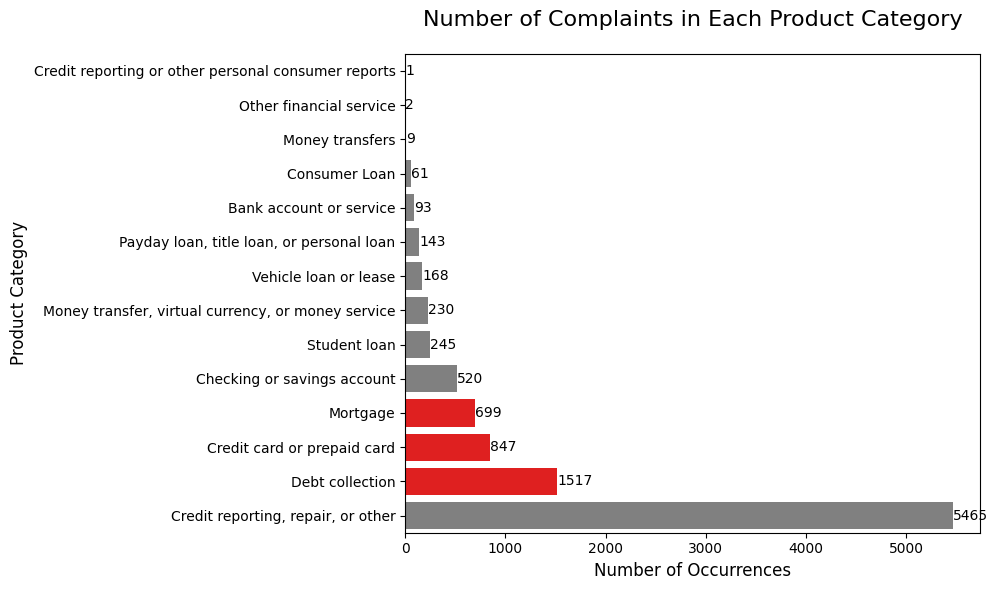

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customizing the color palette
colors = ['grey'] * 10 + ['red'] * 3

# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a barplot using seaborn
sns.barplot(x=product_counts.values, y=product_counts.index, palette=colors)

# Adding a title and labels
plt.title('Number of Complaints in Each Product Category', fontsize=16, pad=20)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Product Category', fontsize=12)

# Customizing tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding data labels on the bars
for i, v in enumerate(product_counts):
    plt.text(v + 0.2, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()


1. Pie Chart:
You can create a pie chart to show the distribution of complaints across different product categories.

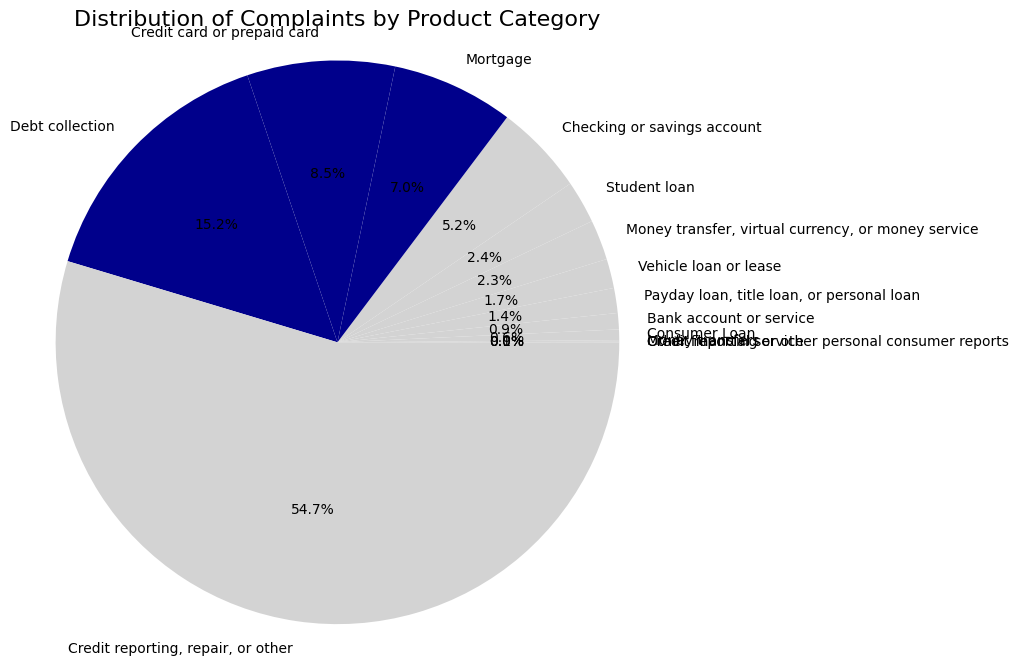

In [14]:
# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Customizing the color palette
colors = ['lightgrey'] * 10 + ['darkblue'] * 3

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(product_counts, labels=product_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Complaints by Product Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


The code uses the TF-IDF vectorization technique to convert text complaints into numerical vectors for analysis. It filters out rare words, considers both single words and pairs of words, removes common English stop words, and assigns labels to the complaints. The resulting TF-IDF matrix can be used for machine learning tasks.

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26339 features (TF-IDF score of unigrams and bigrams)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

# Your TF-IDF vectorization code (initialize tfidf and compute features) goes here

N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())
    unigrams = [feature_names[i] for i in indices[-N:]]
    bigrams = [feature_names[i] for i in indices[-2 * N:-N]]  # Adjusted for bigrams

    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams)))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams)))



==> Bank account or service:
  * Most Correlated Unigrams are: cd, stocks, promotion
  * Most Correlated Bigrams are: branch, overdraft, posting xxxx

==> Checking or savings account:
  * Most Correlated Unigrams are: deposited, overdraft, bank
  * Most Correlated Bigrams are: checking account, funds, checking

==> Consumer Loan:
  * Most Correlated Unigrams are: car, car car, motor
  * Most Correlated Bigrams are: title loan, chrysler capital, vehicle

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: american express, credit card, card
  * Most Correlated Bigrams are: american, express, amex

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: late purpose, 166b creditor, 166b
  * Most Correlated Bigrams are: creditor treat, open end, end consumer

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: 15 1681, bank, 1681 section

==> Debt collection:


Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [17]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

Below provided code performs 5-fold cross-validation for four different classification models (RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression) on a dataset with features (`features`) and labels (`labels`). It then stores the results in a DataFrame called `cv_df`. Here's a summary of what the code does:

1. **Model Initialization:**
   - Four classification models are initialized: RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression. Each model has specific parameters like `n_estimators`, `max_depth`, and `random_state` for RandomForestClassifier and `random_state` for LogisticRegression.

2. **Cross-Validation Setup:**
   - The code sets the number of cross-validation folds (`CV`) to 5. This means the dataset will be split into 5 subsets, and the models will be trained and tested five times, with a different subset as the test set in each iteration.

3. **Cross-Validation Loop:**
   - The code iterates through each model and performs 5-fold cross-validation.
   - For each fold, it records the model's name, fold index, and the accuracy score.

4. **DataFrame Creation:**
   - The results from each fold are collected into a list of entries.
   - A DataFrame called `cv_df` is created using the collected entries, with columns: 'model_name', 'fold_idx', and 'accuracy'. This DataFrame summarizes the model's performance in each fold.

In summary, this code is used to compare the performance of four different classification models using 5-fold cross-validation and stores the results in a DataFrame for further analysis or reporting.

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 

The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [19]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [20]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8236,0.006941
LogisticRegression,0.8054,0.008242
MultinomialNB,0.6794,0.007154
RandomForestClassifier,0.5465,0.000000


In [21]:
# Assuming you have already calculated 'acc' as described in your code

# Print the mean accuracy and standard deviation for each model
for index, row in acc.iterrows():
    model_name = index
    mean_accuracy = row['Mean Accuracy']
    std_deviation = row['Standard deviation']

    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Standard Deviation: {std_deviation}\n")


Model: LinearSVC
Mean Accuracy: 0.8236000000000001
Standard Deviation: 0.00694082127705359

Model: LogisticRegression
Mean Accuracy: 0.8054
Standard Deviation: 0.008241662453655775

Model: MultinomialNB
Mean Accuracy: 0.6794
Standard Deviation: 0.007153670386591765

Model: RandomForestClassifier
Mean Accuracy: 0.5465
Standard Deviation: 0.0



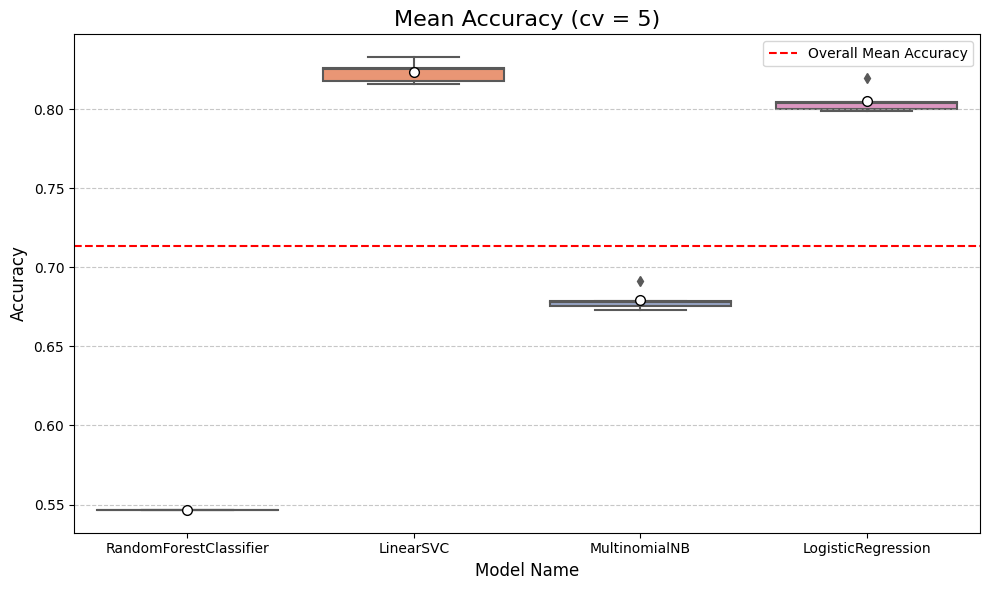

In [22]:
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Customize the color palette for the box plot
palette = sns.color_palette("Set2")

# Create the box plot with improved aesthetics
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            palette=palette,  # Use the custom color palette
            showmeans=True,
            meanprops={'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'white', 'markersize':7})

# Add a title and labels
plt.title("Mean Accuracy (cv = 5)", size=16)
plt.xlabel("Model Name", size=12)
plt.ylabel("Accuracy", size=12)

# Rotate x-axis labels for better readability if needed
# plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for the mean of all models
overall_mean_accuracy = cv_df['accuracy'].mean()
plt.axhline(y=overall_mean_accuracy, color='red', linestyle='--', label='Overall Mean Accuracy')

# Add legend for the overall mean accuracy line
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


####Model Evaluation

In [23]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###Precision, Recall, F1-score

In [25]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred))


				CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1386
           1       0.85      0.90      0.88       183
           2       0.65      0.78      0.71       128
           3       0.69      0.68      0.69       203
           4       0.72      0.71      0.71       368
           5       0.79      0.59      0.67        63
           6       0.57      0.12      0.21        32
           7       0.84      0.74      0.79        62
           8       0.00      0.00      0.00        17
           9       0.30      0.23      0.26        26
          10       0.00      0.00      0.00        30
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.81      2500
   macro avg       0.48      0.44      0.45      2500
weighted avg       0.79      0.81      0.80      2500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

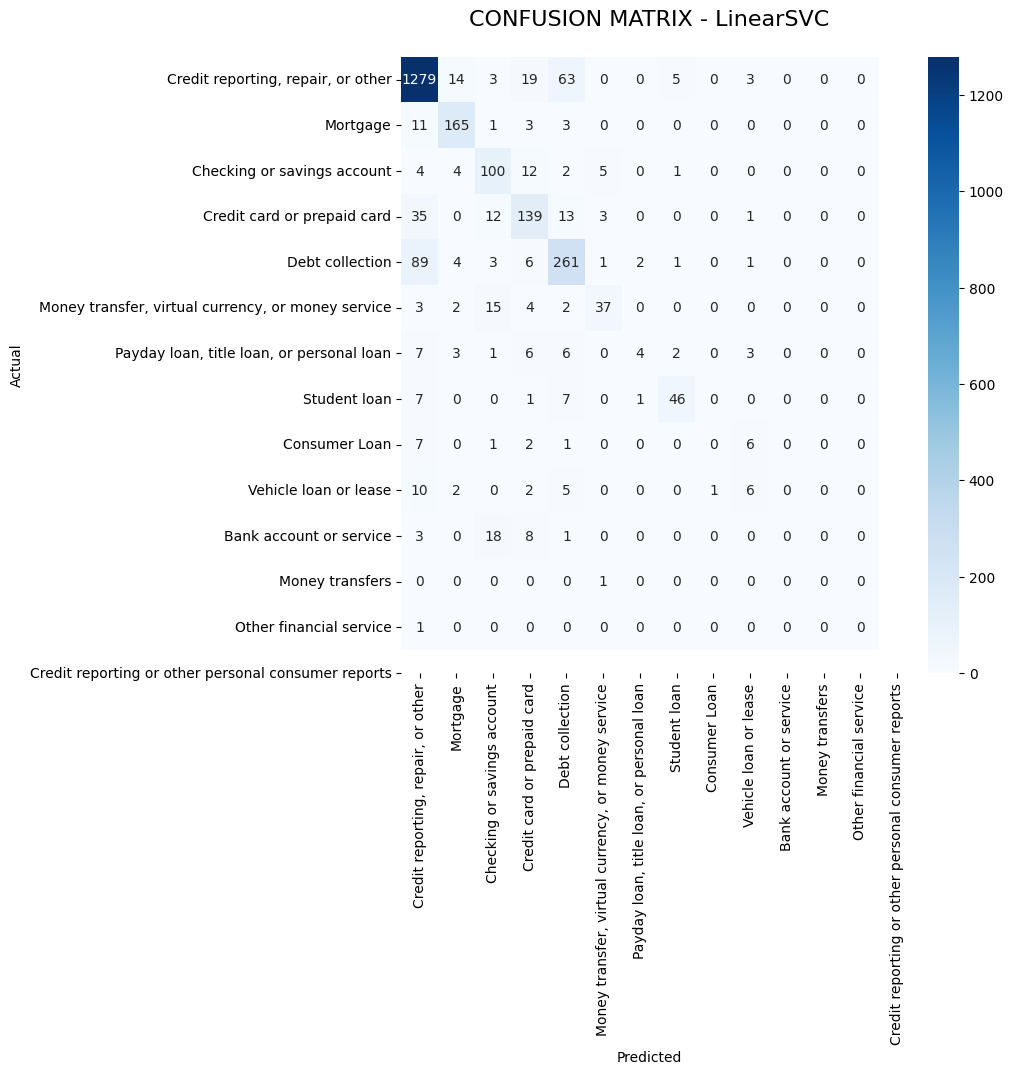

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [31]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual-1, predicted-1] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Debt collection' predicted as 'Mortgage' : 4 examples.


,Product,Consumer_complaint
3910054,Debt collection,"On XX/XX/2019, PennyMac Corp, was served with ..."
1736649,Debt collection,"Around XXXX of XXXX, my mortgage service provi..."
1414862,Debt collection,Seterus continues to harass me and while I hav...
790848,Debt collection,"On XXXX XXXX, XXXX to this Day XXXX XXXX, XXXX..."



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 2 examples.


,Product,Consumer_complaint
1685209,"Money transfer, virtual currency, or money ser...",In an effort to close on our home loan today X...
2929181,"Money transfer, virtual currency, or money ser...",I transferred money to a contractor who lied t...



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 0 examples.


,Product,Consumer_complaint


#### Most correlated terms with each category

In [33]:
model.fit(features, labels)
N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf. get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))



==> 'Bank account or service':
  * Top unigrams: bank, promotion, branch, 2016
  * Top bigrams: xxxx 2015, xx 2016, bank did, checking account

==> 'Checking or savings account':
  * Top unigrams: bank, savings, chime, checking
  * Top bigrams: debit card, savings account, 36 00, overdraft fees

==> 'Consumer Loan':
  * Top unigrams: car, motor, vehicle, acceptance
  * Top bigrams: xxxx 16, report owe, going pay, auto xxxx

==> 'Credit card or prepaid card':
  * Top unigrams: card, amex, purchase, capital
  * Top bigrams: american express, pay balance, missed payment, care credit

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: 166b, usc, 604, purpose
  * Top bigrams: 166b creditor, 15 usc, xxxx violated, late purpose

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, inquiries
  * Top bigrams: victim identity, xxxx xxxx, experian xxxx, late payments

==> 'Debt collection':
  * Top unigrams: debt, recovery, collecti

## Predictions

Now let's make a few predictions on unseen data.<br>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [35]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [36]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id


Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [37]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [38]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


In [43]:
new_complaint = """I've encountered a problem with a recent bank money transfer. Please investigate and resolve it promptly."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Money transfer, virtual currency, or money service']


In [44]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


In [45]:
new_complaint = """I am deeply frustrated with my vehicle loan from SBI Bank .
Despite timely payments, they continue to harass me for outstanding amounts and have reported inaccurate late payments to credit agencies.
 This jeopardizes my credit score and financial stability.
 I urgently request resolution to this issue to ensure accurate reporting and protect my financial standing."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Credit reporting, repair, or other']


In [46]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
